In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob 
from numpy.linalg import eig
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from typing import List, Set, Dict, Tuple, Optional

import seaborn as sns
%matplotlib inline

In [3]:
# Get names of historical data files and store sector ETF tickers in a list 
data = [f for f in glob.glob('*.csv')]
tickers = [f[0:3] for f in data]

# Names of Sector ETFs
names = ["Mat", "Enrgy", "Fins", "Indu", "Tech", "Stpl", "Util", "Health", "Disc" ]

# Create a mapping from tickers to names (maybe useful)
tick_to_name = dict(zip(tickers,names))


#### Pull closing prices from each "sector".csv file into a Pandas Dataframe

In [4]:
df_sec = pd.concat([pd.read_csv(f, usecols=[0,5], index_col = [0]) for f in data], ignore_index = True, axis = 1)
df_sec.columns = names
df_sec.head()

,Mat,Enrgy,Fins,Indu,Tech,Stpl,Util,Health,Disc
Date,,,,,,,,,
1998-12-22,13.326187,16.030661,9.767839,16.370098,25.580147,17.100040,14.737362,19.090425,20.134567
1998-12-23,13.466161,16.364420,9.911845,16.655781,26.191339,17.513418,14.675605,19.519430,20.221031
1998-12-24,13.776071,16.278292,9.977332,16.875517,26.091562,17.483175,14.945813,19.638632,20.591616
1998-12-28,13.656102,16.192167,9.846398,16.963413,26.166361,17.382345,14.868592,19.352631,20.406319
1998-12-29,13.906034,16.353655,9.951146,17.205086,26.241230,17.765488,15.115628,19.781630,20.851015


#### Pull closing prices for the S&P 500

In [5]:
df_spx = pd.read_csv("SPX/^GSPC.csv", usecols = [0,5], index_col=[0], parse_dates=True)
df_spx.columns = ["SPX"]
df_spx.head()

,SPX
Date,
1998-12-22,1203.569946
1998-12-23,1228.540039
1998-12-24,1226.270020
1998-12-28,1225.489990
1998-12-29,1241.810059


#### Calculate returns for each sector and the S&P 500

In [6]:
ret_sec = df_sec.pct_change().dropna()
ret_spx = df_spx.pct_change().dropna()
ret_sec.head()

,Mat,Enrgy,Fins,Indu,Tech,Stpl,Util,Health,Disc
Date,,,,,,,,,
1998-12-23,0.010504,0.020820,0.014743,0.017452,0.023893,0.024174,-0.004191,0.022472,0.004294
1998-12-24,0.023014,-0.005263,0.006607,0.013193,-0.003810,-0.001727,0.018412,0.006107,0.018327
1998-12-28,-0.008709,-0.005291,-0.013123,0.005208,0.002867,-0.005767,-0.005167,-0.014563,-0.008999
1998-12-29,0.018302,0.009973,0.010638,0.014247,0.002861,0.022042,0.016615,0.022167,0.021792
1998-12-30,-0.002876,-0.015142,-0.003949,-0.004471,-0.003802,-0.006243,-0.008172,-0.008436,-0.008294


####   Sector ETF Correlation Matrix

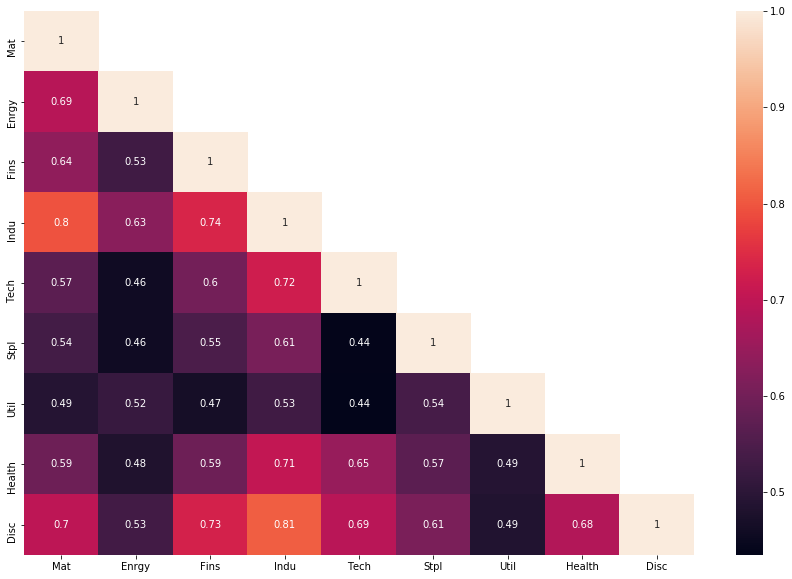

In [10]:
cor_mat = ret_sec.corr()

plt.figure(figsize =(15,10))
mask = np.zeros_like(cor_mat, dtype=np.bool)
mask[np.triu_indices_from(mask, k = 1)] = True
sns.heatmap(cor_mat, mask=mask, annot=True)

In [38]:
eigVals, eigVecs = np.linalg.eig(cor_mat)


In [48]:
corr_check = eigVecs.dot(np.diag(eigVals)).dot(eigVecs.T)


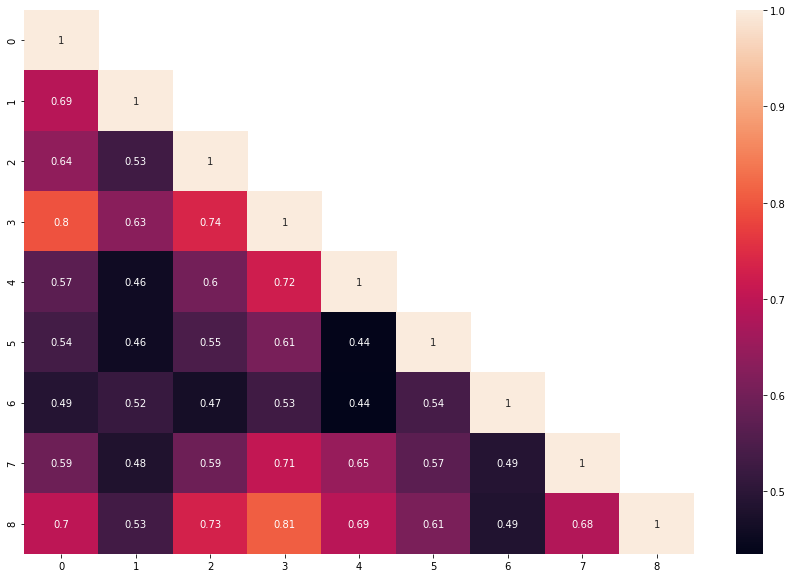

In [49]:
plt.figure(figsize =(15,10))
mask = np.zeros_like(corr_check, dtype=np.bool)
mask[np.triu_indices_from(mask, k = 1)] = True
sns.heatmap(corr_check, mask=mask, annot=True)